In [228]:
def normalize(X):
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    
    return (X-mean)/std

def train_test_split(X,y):
    n = X.shape[0]
    trainX = X[:n-37,:]
    trainy = y[:n-37]
    testX = X[n-37:,:]
    testy = y[n-37:]
    
    return trainX, trainy, testX, testy

def kfold(X,y,k):
    n = X.shape[0]
    nSample = int(np.ceil(n/k))
    Xfold = {}
    yfold = {}
    
    for i in range(k):
        if i!=k:
            Xfold[i] = X[i*nSample:(i+1)*nSample,:]
            yfold[i] = y[i*nSample:(i+1)*nSample]
        else:
            Xfold[i] = X[i*nSample:,:]
            yfold[i] = y[i*nSample:]
    
    return Xfold,yfold

def get_lrn_val(Xfold,yfold,i,k):
    Xval = Xfold[i]
    yval = yfold[i]
    
    m = Xfold[0].shape[1]
    Xlrn = np.empty((0,m))
    ylrn = np.empty((0,))
    for j in range(k):
        if j != i:
            Xlrn = np.concatenate((Xlrn,Xfold[j]),axis=0)
            ylrn = np.concatenate((ylrn,yfold[j]))
    
    return Xlrn,ylrn,Xval,yval

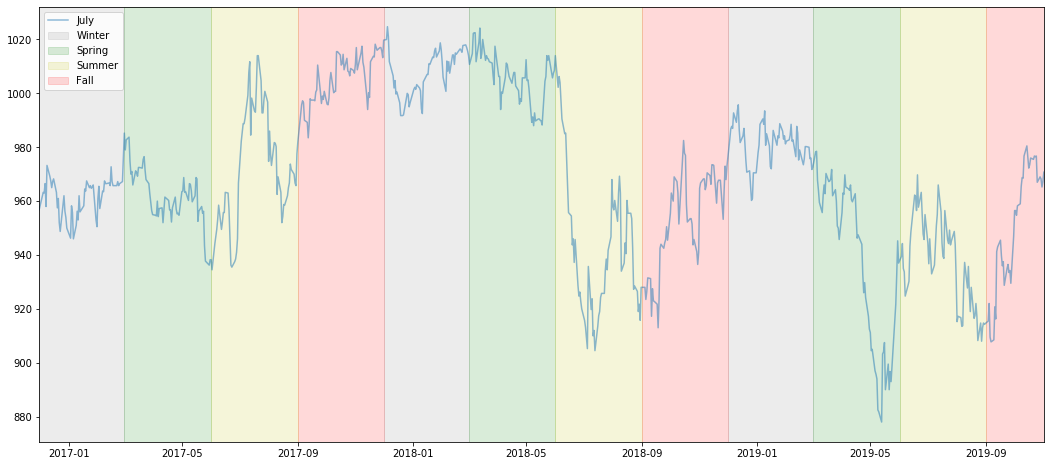

In [4]:
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as metric
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor

# Read data
july_old = pd.read_csv('july2020.csv')
july = pd.read_csv('july2020_updated.csv')

july_old['Date'] = pd.to_datetime(july_old['Date'])
july['Date'] = pd.to_datetime(july['Date'])

# Plot the july closing price for verification
h = plt.figure(figsize=(18,8))
h = plt.plot(july['Date'],july['Close'],label='July',alpha=0.5)


seasonLine = ['2016-12-1','2017-03-1','2017-06-1','2017-09-1','2017-12-1','2018-03-1','2018-06-1','2018-09-1','2018-12-1','2019-03-1','2019-06-1','2019-09-1','2019-11-1']
c = ['grey','g','y','r','grey','g','y','r','grey','g','y','r']
l = ['Winter','Spring','Summer','Fall','Winter','Spring','Summer','Fall','Winter','Spring','Summer','Fall']
for i in range(len(seasonLine)-1):
    if (i < 4):
        plt.axvspan(seasonLine[i], seasonLine[i+1], alpha=0.15, color=c[i],label=l[i])
    else:
        plt.axvspan(seasonLine[i], seasonLine[i+1], alpha=0.15, color=c[i])
h = plt.legend()
h = plt.xlim(['2016-12-1','2019-11-1'])

### The july New data (data found in www.barchart.com) is exactly the same as the data provided by mudac

### First we try how many day before day i should we considered

In [317]:
# Encode input X with different dimension
X9 = np.array([[july.loc[i-9,'Close'],july.loc[i-8,'Close'],july.loc[i-7,'Close'],july.loc[i-6,'Close'],july.loc[i-5,'Close'],july.loc[i-4,'Close'],july.loc[i-3,'Close'],july.loc[i-2,'Close'],july.loc[i-1,'Close'],july.loc[i,'Close']] for i in range(9,n-5)])
X8 = np.array([[july.loc[i-8,'Close'],july.loc[i-7,'Close'],july.loc[i-6,'Close'],july.loc[i-5,'Close'],july.loc[i-4,'Close'],july.loc[i-3,'Close'],july.loc[i-2,'Close'],july.loc[i-1,'Close'],july.loc[i,'Close']] for i in range(9,n-5)])
X7 = np.array([[july.loc[i-7,'Close'],july.loc[i-6,'Close'],july.loc[i-5,'Close'],july.loc[i-4,'Close'],july.loc[i-3,'Close'],july.loc[i-2,'Close'],july.loc[i-1,'Close'],july.loc[i,'Close']] for i in range(9,n-5)])
X6 = np.array([[july.loc[i-6,'Close'],july.loc[i-5,'Close'],july.loc[i-4,'Close'],july.loc[i-3,'Close'],july.loc[i-2,'Close'],july.loc[i-1,'Close'],july.loc[i,'Close']] for i in range(9,n-5)])
X5 = np.array([[july.loc[i-5,'Close'],july.loc[i-4,'Close'],july.loc[i-3,'Close'],july.loc[i-2,'Close'],july.loc[i-1,'Close'],july.loc[i,'Close']] for i in range(9,n-5)])
X4 = np.array([[july.loc[i-4,'Close'],july.loc[i-3,'Close'],july.loc[i-2,'Close'],july.loc[i-1,'Close'],july.loc[i,'Close']] for i in range(9,n-5)])
X3 = np.array([[july.loc[i-3,'Close'],july.loc[i-2,'Close'],july.loc[i-1,'Close'],july.loc[i,'Close']] for i in range(9,n-5)])
X2 = np.array([[july.loc[i-2,'Close'],july.loc[i-1,'Close'],july.loc[i,'Close']] for i in range(9,n-5)])
X1 = np.array([[july.loc[i-1,'Close'],july.loc[i,'Close']] for i in range(9,n-5)])
X0 = np.array([[july.loc[i,'Close']] for i in range(9,n-5)])

# Encode y
y = {}
for j in range(5):
    y[j] = np.array([july.loc[i,'Close'] for i in range(9+j+1,n-5+j+1)])

print('X9: ', X9.shape,' X8: ',X8.shape, ' X7: ',X7.shape, ' X6: ',X6.shape, ' X5: ',X5.shape)
print('X4: ', X4.shape,' X3: ',X3.shape, ' X2: ',X2.shape, ' X1: ',X1.shape, ' X0: ',X0.shape, '\n')

Xi = {0:X0,1:X1,2:X2,3:X3,4:X4,5:X5,6:X6,7:X7,8:X8,9:X9}
Xidx = ['X0','X1','X2','X3','X4','X5','X6','X7','X8','X9']

# perform linear regression on reach X
for idx in range(len(Xidx)):
    # Perform normalization on X
    Xdata = normalize(Xi[idx])

    trainError = np.zeros((5,))
    testError = np.zeros((5,))

    # For each y, perform linear regression
    for i in range(5):
        Xtrain, ytrain, Xtest, ytest = train_test_split(Xdata,y[i])

        linearModel = LinearRegression()
        linearModel.fit(Xtrain,ytrain)
        ypredTrain = linearModel.predict(Xtrain)
        trainError[i] = metric.mean_squared_error(ytrain,ypredTrain)

        ypredTest = linearModel.predict(Xtest)
        testError[i] = metric.mean_squared_error(ytest,ypredTest)

    print(Xidx[idx],' Train Error: ', trainError, ' avg:',trainError.mean())
    print(Xidx[idx],' Test Error: ', testError, ' avg:',testError.mean(), '\n')

    
### Conclusion: using only day i as input X has roughly the same averaged test error as the rest of input X to 
### predict day i+1, suggesting closed price on day i is the best predictor to day i+1. 

X9:  (729, 10)  X8:  (729, 9)  X7:  (729, 8)  X6:  (729, 7)  X5:  (729, 6)
X4:  (729, 5)  X3:  (729, 4)  X2:  (729, 3)  X1:  (729, 2)  X0:  (729, 1) 

X0  Train Error:  [ 44.92066359  81.61372779 119.72588295 154.01869043 186.99578303]  avg: 117.45494955962621
X0  Test Error:  [ 46.49251188  84.23515117 130.12001995 162.63829891 195.05404801]  avg: 123.70800598292571 

X1  Train Error:  [ 44.67700558  81.54581922 119.52867233 153.81622712 186.74513422]  avg: 117.26257169384758
X1  Test Error:  [ 46.53313922  84.73961745 130.5027645  163.40164515 195.20860277]  avg: 124.07715381925746 

X2  Train Error:  [ 44.64442164  81.54579561 119.52767011 153.80930093 186.74468683]  avg: 117.25437502386794
X2  Test Error:  [ 46.2094928   84.74378313 130.55172381 163.41217298 195.20438965]  avg: 124.02431247569193 

X3  Train Error:  [ 44.61585309  81.5082733  119.47104652 153.77619916 186.74458429]  avg: 117.22319127057361
X3  Test Error:  [ 46.09365613  84.71653443 130.2171314  163.19009257 195.20

In [322]:
# Check the coefficient of the linear regression
linearModel.coef_

### Here we see the last feature has the highest weight, corresponds to day i.

array([-4.43496359,  3.26766884, -0.07429043,  0.82314732, -1.26180721,
        2.72556309, -1.02299184, -0.04428153,  1.94425095, 25.87922454])

### What about the mean of closed price?

In [323]:
# Encode input X with different dimension
X9 = np.array([[july.loc[i-9,'Close'],july.loc[i-8,'Close'],july.loc[i-7,'Close'],july.loc[i-6,'Close'],july.loc[i-5,'Close'],july.loc[i-4,'Close'],july.loc[i-3,'Close'],july.loc[i-2,'Close'],july.loc[i-1,'Close'],july.loc[i,'Close']] for i in range(9,n-5)]).mean(axis=1).reshape((-1,1))
X8 = np.array([[july.loc[i-8,'Close'],july.loc[i-7,'Close'],july.loc[i-6,'Close'],july.loc[i-5,'Close'],july.loc[i-4,'Close'],july.loc[i-3,'Close'],july.loc[i-2,'Close'],july.loc[i-1,'Close'],july.loc[i,'Close']] for i in range(9,n-5)]).mean(axis=1).reshape((-1,1))
X7 = np.array([[july.loc[i-7,'Close'],july.loc[i-6,'Close'],july.loc[i-5,'Close'],july.loc[i-4,'Close'],july.loc[i-3,'Close'],july.loc[i-2,'Close'],july.loc[i-1,'Close'],july.loc[i,'Close']] for i in range(9,n-5)]).mean(axis=1).reshape((-1,1))
X6 = np.array([[july.loc[i-6,'Close'],july.loc[i-5,'Close'],july.loc[i-4,'Close'],july.loc[i-3,'Close'],july.loc[i-2,'Close'],july.loc[i-1,'Close'],july.loc[i,'Close']] for i in range(9,n-5)]).mean(axis=1).reshape((-1,1))
X5 = np.array([[july.loc[i-5,'Close'],july.loc[i-4,'Close'],july.loc[i-3,'Close'],july.loc[i-2,'Close'],july.loc[i-1,'Close'],july.loc[i,'Close']] for i in range(9,n-5)]).mean(axis=1).reshape((-1,1))
X4 = np.array([[july.loc[i-4,'Close'],july.loc[i-3,'Close'],july.loc[i-2,'Close'],july.loc[i-1,'Close'],july.loc[i,'Close']] for i in range(9,n-5)]).mean(axis=1).reshape((-1,1))
X3 = np.array([[july.loc[i-3,'Close'],july.loc[i-2,'Close'],july.loc[i-1,'Close'],july.loc[i,'Close']] for i in range(9,n-5)]).mean(axis=1).reshape((-1,1))
X2 = np.array([[july.loc[i-2,'Close'],july.loc[i-1,'Close'],july.loc[i,'Close']] for i in range(9,n-5)]).mean(axis=1).reshape((-1,1))
X1 = np.array([[july.loc[i-1,'Close'],july.loc[i,'Close']] for i in range(9,n-5)]).mean(axis=1).reshape((-1,1))
X0 = np.array([[july.loc[i,'Close']] for i in range(9,n-5)]).mean(axis=1).reshape((-1,1))

# Encode y
y = {}
for j in range(5):
    y[j] = np.array([july.loc[i,'Close'] for i in range(9+j+1,n-5+j+1)])

print('X9: ', X9.shape,' X8: ',X8.shape, ' X7: ',X7.shape, ' X6: ',X6.shape, ' X5: ',X5.shape)
print('X4: ', X4.shape,' X3: ',X3.shape, ' X2: ',X2.shape, ' X1: ',X1.shape, ' X0: ',X0.shape, '\n')

Xi = {0:X0,1:X1,2:X2,3:X3,4:X4,5:X5,6:X6,7:X7,8:X8,9:X9}
Xidx = ['X0','X1','X2','X3','X4','X5','X6','X7','X8','X9']

# perform linear regression on reach X
for idx in range(len(Xidx)):
    # Perform normalization on X
    Xdata = normalize(Xi[idx])

    trainError = np.zeros((5,))
    testError = np.zeros((5,))

    # For each y, perform linear regression
    for i in range(5):
        Xtrain, ytrain, Xtest, ytest = train_test_split(Xdata,y[i])

        linearModel = LinearRegression()
        linearModel.fit(Xtrain,ytrain)
        ypredTrain = linearModel.predict(Xtrain)
        trainError[i] = metric.mean_squared_error(ytrain,ypredTrain)

        ypredTest = linearModel.predict(Xtest)
        testError[i] = metric.mean_squared_error(ytest,ypredTest)

    print(Xidx[idx],' Train Error: ', trainError, ' avg:',trainError.mean())
    print(Xidx[idx],' Test Error: ', testError, ' avg:',testError.mean(), '\n')

    
### Conclusion: the result here agrees with the previous case where day i is the best predictor to day i+1, i+2, i+3, i+4, and i+5

X9:  (729, 1)  X8:  (729, 1)  X7:  (729, 1)  X6:  (729, 1)  X5:  (729, 1)
X4:  (729, 1)  X3:  (729, 1)  X2:  (729, 1)  X1:  (729, 1)  X0:  (729, 1) 

X0  Train Error:  [ 44.92066359  81.61372779 119.72588295 154.01869043 186.99578303]  avg: 117.45494955962621
X0  Test Error:  [ 46.49251188  84.23515117 130.12001995 162.63829891 195.05404801]  avg: 123.70800598292571 

X1  Train Error:  [ 52.53487797  90.39317627 126.96907784 160.90932648 193.26808279]  avg: 124.81490826879103
X1  Test Error:  [ 56.07111045  99.25747283 139.78965535 173.7097389  200.78117258]  avg: 133.92183002252355 

X2  Train Error:  [ 64.1214337  101.16611871 136.88569363 170.22452211 202.38176601]  avg: 134.95590683198319
X2  Test Error:  [ 72.09112354 113.1795242  152.40814824 182.61161536 206.78992861]  avg: 145.41606799002324 

X3  Train Error:  [ 75.69661985 112.09641605 147.0227142  180.04540676 212.39857541]  avg: 145.45194645424846
X3  Test Error:  [ 86.71442712 127.05295207 162.49437921 190.66356841 215.216

### Based on the analysis above, it seems like selecting day i as input X is the valid choice. Therefore, the input X and output y is defined as followed:
\begin{align}
    X &= x_{i} \\
    y &= x_{i+1},x_{i+2},x_{i+3},x_{i+4},x_{i+5} 
\end{align}
### where $x_i$ is the closing price at day i and output y is the closing price at day $i+\alpha$, where $\alpha=1,...,5$.

In [325]:
# Encode input X and output y
n = july.shape[0]
X = np.array([[july.loc[i,'Close']] for i in range(0,n-5)])
y = {}
for j in range(5):
    y[j] = np.array([july.loc[i,'Close'] for i in range(0+j+1,n-5+j+1)])



print('X size: ', X.shape, ' y size: ', y[0].shape)

### We have 734 samples

X size:  (738, 1)  y size:  (738,)


### Perform regression methods

### Linear Regression

Linear Regression
Train Error:  [ 44.74853723  81.068485   118.75362054 152.93251554 185.71969689] 

Test Error:  [ 46.39102238  83.86909868 129.40429937 161.54578662 193.37426082] 



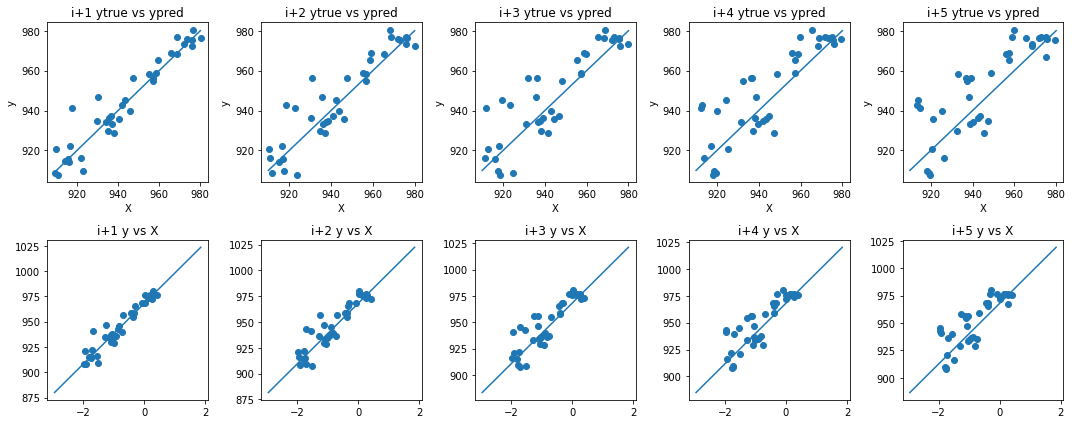

In [330]:
print('Linear Regression')

# Perform normalization on X
X = normalize(X)

trainError = np.zeros((5,))
testError = np.zeros((5,))

# Plot subplot
fig, axs = plt.subplots(2,5, tight_layout=True, figsize = (15,6))

# For each y, perform linear regression
for i in range(5):
    Xtrain, ytrain, Xtest, ytest = train_test_split(X,y[i])

    linearModel = LinearRegression()
    linearModel.fit(Xtrain,ytrain)
    ypredTrain = linearModel.predict(Xtrain)
    trainError[i] = metric.mean_squared_error(ytrain,ypredTrain)

    ypredTest = linearModel.predict(Xtest)
    testError[i] = metric.mean_squared_error(ytest,ypredTest)
    
    # plot predicted y vs true y
    h = axs[0][i].scatter(ypredTest,ytest)
    h = axs[0][i].plot(np.linspace(910,980),np.linspace(910,980))
    h = axs[0][i].set_title('i+%d ytrue vs ypred' % (i+1))
    h = axs[0][i].set_xlabel('ypred')
    h = axs[0][i].set_ylabel('ytrue')
    
    # plot the figure
    coef = linearModel.coef_
    intercept = linearModel.intercept_
    x1 = np.linspace(Xtrain.min(),Xtrain.max())
    x2 = x1*coef +intercept
    h = axs[1][i].scatter(Xtest,ytest)
    h = axs[1][i].plot(x1,x2)
    h = axs[1][i].set_title('i+%d y vs X' % (i+1))
    h = axs[0][i].set_xlabel('X')
    h = axs[0][i].set_ylabel('y')

print('Train Error: ', trainError, '\n')
print('Test Error: ', testError, '\n')

### y with x_i+1 has the best result 

### Projection Pursuit

Projection Pursuit
For model 0 - opt r:  1  opt val error:  47.50864896221359  train error:  44.52579326063968  test error:  46.27043560309322
For model 1 - opt r:  7  opt val error:  85.70611153472458  train error:  80.64540098347236  test error:  84.04537774041579
For model 2 - opt r:  2  opt val error:  126.43786999919048  train error:  117.42732166853048  test error:  128.6073934505246
For model 3 - opt r:  4  opt val error:  162.84043422131955  train error:  151.27377268875634  test error:  159.28215784814702
For model 4 - opt r:  1  opt val error:  197.99634012257275  train error:  183.19951721466296  test error:  189.30687699703364


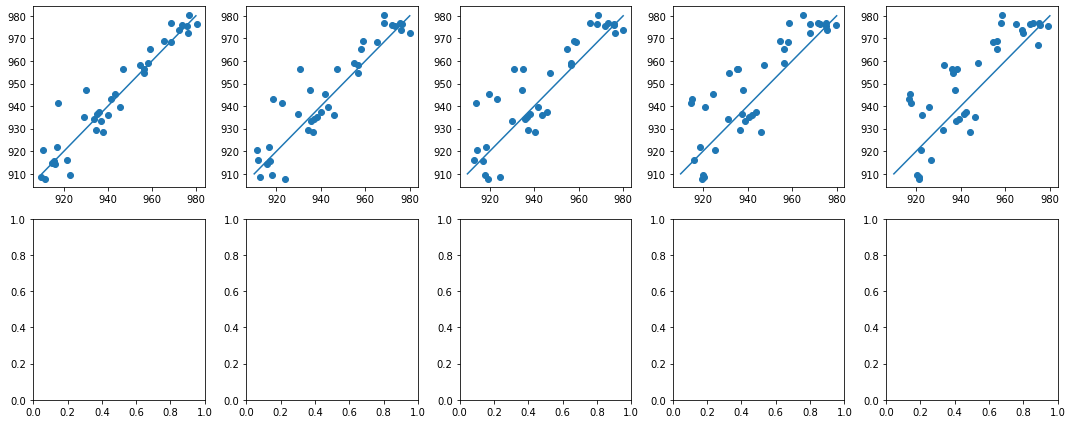

In [327]:
### Projection Pursuit
from skpp import ProjectionPursuitRegressor
print('Projection Pursuit')

# PP Parameter
units = [1, 2, 3, 4, 5, 6, 7, 8]

# Plot subplot
fig, axs = plt.subplots(2,5, tight_layout=True, figsize = (15,6))

# For each y, perform projection pursuit
for i in range(5):
    Xtrain, ytrain, Xtest, ytest = train_test_split(X,y[i])
    
    # Split into 5-fold for complexity tuning
    K = 5
    Xfold,yfold = kfold(Xtrain,ytrain,K)
    
    # For each parameter unit
    avgLrnError = np.zeros((len(units),))
    avgValError = np.zeros((len(units),))
    for idx,unit in enumerate(units): 
    
        # for each fold
        lrnError=np.zeros((K,))
        valError=np.zeros((K,))
        for k in range(K):
            Xlrn,ylrn,Xval,yval=get_lrn_val(Xfold,yfold,k,K)

            model = ProjectionPursuitRegressor(r=unit)
            ypred_lrn = model.fit(Xlrn,ylrn).predict(Xlrn)
            lrnError[k] = metric.mean_squared_error(ylrn,ypred_lrn)

            ypred_val = model.predict(Xval)
            valError[k] = metric.mean_squared_error(yval,ypred_val)
        
        # Find average lrn and val error
        avgLrnError[idx] = lrnError.mean()
        avgValError[idx] = valError.mean()
    
    # Find lowest validation error and its corresponding parameter
    opt_unit = units[np.argmin(avgValError)]
    opt_val_error = np.min(avgValError)
    
    # Train using all training data on the optimal unit
    opt_model = ProjectionPursuitRegressor(r=opt_unit)
    ypred_trn = opt_model.fit(Xtrain,ytrain).predict(Xtrain)
    trnError = metric.mean_squared_error(ytrain,ypred_trn)
    
    # Test
    ypred_tst = opt_model.predict(Xtest)
    tstError = metric.mean_squared_error(ytest,ypred_tst)
    
    print('For model %d - opt r: ' % (i), opt_unit, ' opt val error: ',opt_val_error, ' train error: ', trnError, ' test error: ', tstError)
    
    # plot predicted y vs true y
    h = axs[0][i].scatter(ypred_tst,ytest)
    h = axs[0][i].plot(np.linspace(910,980),np.linspace(910,980))

### Ridge Regression

Ridge Regression
For model 0 - opt alpha:  0.5  opt val:  45.8874  train error:  44.587  test error:  46.0161
For model 1 - opt alpha:  0.0009765625  opt val:  83.8522  train error:  81.3389  test error:  84.3367
For model 2 - opt alpha:  0.0625  opt val:  123.4475  train error:  118.9868  test error:  129.698
For model 3 - opt alpha:  0.0009765625  opt val:  159.9166  train error:  153.2297  test error:  162.5245
For model 4 - opt alpha:  0.25  opt val:  195.4827  train error:  185.9427  test error:  195.3378


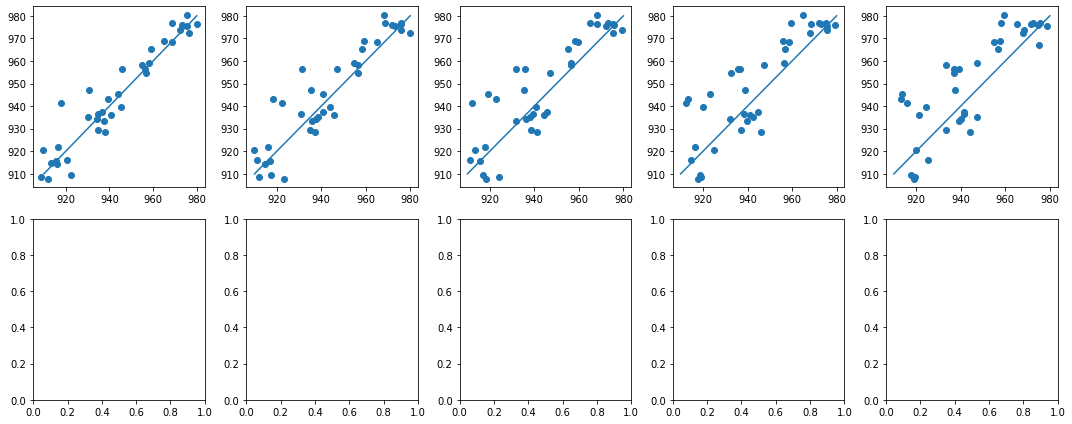

In [282]:
### Ridge Regression
from sklearn.linear_model import Ridge
print('Ridge Regression')

# alpha Parameter
units = [2**i for i in range(-10,10)]

# Plot subplot
fig, axs = plt.subplots(2,5, tight_layout=True, figsize = (15,6))

# For each y, perform ridge regression
for i in range(5):
    Xtrain, ytrain, Xtest, ytest = train_test_split(X,y[i])
    
    # Split into 5-fold for complexity tuning
    K = 5
    Xfold,yfold = kfold(Xtrain,ytrain,K)
    
    # For each parameter unit
    avgLrnError = np.zeros((len(units),))
    avgValError = np.zeros((len(units),))
    for idx,unit in enumerate(units): 
    
        # for each fold
        lrnError=np.zeros((K,))
        valError=np.zeros((K,))
        for k in range(K):
            Xlrn,ylrn,Xval,yval=get_lrn_val(Xfold,yfold,k,K)

            model = Ridge(alpha=unit)
            ypred_lrn = model.fit(Xlrn,ylrn).predict(Xlrn)
            lrnError[k] = metric.mean_squared_error(ylrn,ypred_lrn)

            ypred_val = model.predict(Xval)
            valError[k] = metric.mean_squared_error(yval,ypred_val)
        
        # Find average lrn and val error
        avgLrnError[idx] = lrnError.mean()
        avgValError[idx] = valError.mean()
    
    # Find lowest validation error and its corresponding parameter
    opt_unit = units[np.argmin(avgValError)]
    opt_val_error = np.min(avgValError)
    
    # Train using all training data on the optimal unit
    opt_model = Ridge(alpha=opt_unit)
    ypred_trn = opt_model.fit(Xtrain,ytrain).predict(Xtrain)
    trnError = metric.mean_squared_error(ytrain,ypred_trn)
    
    # Test
    ypred_tst = opt_model.predict(Xtest)
    tstError = metric.mean_squared_error(ytest,ypred_tst)
    
    print('For model %d - opt alpha: ' % (i), opt_unit, ' opt val: ', round(opt_val_error,4), ' train error: ', round(trnError,4), ' test error: ', round(tstError,4))
    
    # plot predicted y vs true y
    h = axs[0][i].scatter(ypred_tst,ytest)
    h = axs[0][i].plot(np.linspace(910,980),np.linspace(910,980))

### Linear SVR

Linear SVR
For model 0 - opt eps: 0 opt C: 32  train error:  44.9037  test error:  47.3108
For model 1 - opt eps: 5 opt C: 16  train error:  81.5286  test error:  86.3325
For model 2 - opt eps: 7 opt C: 16  train error:  119.7122  test error:  139.4156
For model 3 - opt eps: 0 opt C: 128  train error:  154.3672  test error:  160.1755
For model 4 - opt eps: 0 opt C: 64  train error:  187.0974  test error:  191.3955


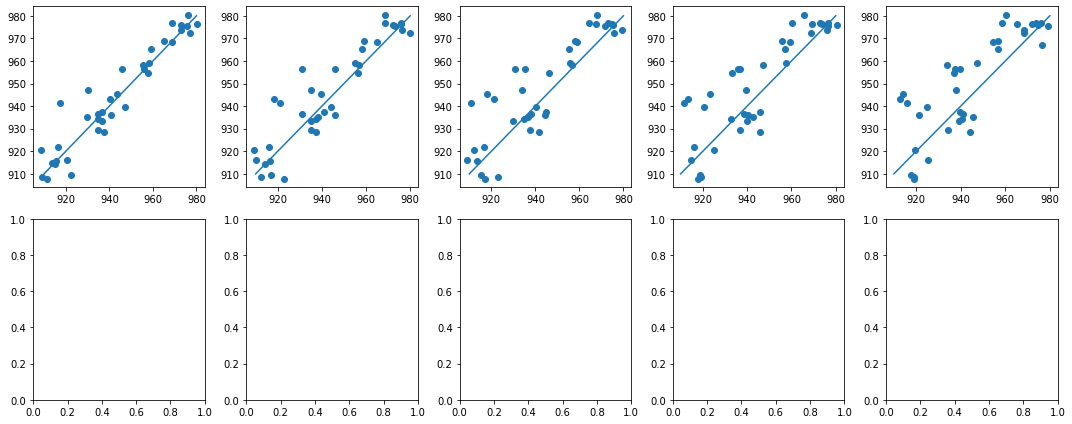

In [276]:
from sklearn.svm import SVR
print('Linear SVR')

# eps Parameter
units = [i for i in range(0,10)]

# C parameter
units2 = [2**i for i in range(-10,10)]

# Plot subplot
fig, axs = plt.subplots(2,5, tight_layout=True, figsize = (15,6))

# For each y, perform linear SVR
for i in range(5):
    Xtrain, ytrain, Xtest, ytest = train_test_split(X,y[i])
    
    # Split into 5-fold for complexity tuning
    K = 5
    Xfold,yfold = kfold(Xtrain,ytrain,K)
    
    # For each parameter unit
    avgLrnError = np.zeros((len(units),len(units2)))
    avgValError = np.zeros((len(units),len(units2)))
    for idx,unit in enumerate(units): 
        for idx2,unit2 in enumerate(units2):
    
            # for each fold
            lrnError=np.zeros((K,))
            valError=np.zeros((K,))
            for k in range(K):
                Xlrn,ylrn,Xval,yval=get_lrn_val(Xfold,yfold,k,K)

                model = SVR(C=unit2,epsilon=unit,kernel='linear')
                ypred_lrn = model.fit(Xlrn,ylrn).predict(Xlrn)
                lrnError[k] = metric.mean_squared_error(ylrn,ypred_lrn)

                ypred_val = model.predict(Xval)
                valError[k] = metric.mean_squared_error(yval,ypred_val)

            # Find average lrn and val error
            avgLrnError[idx,idx2] = lrnError.mean()
            avgValError[idx,idx2] = valError.mean()
    
    # Find lowest validation error and its corresponding parameter
    opt_params = np.unravel_index(np.argmin(avgValError, axis=None), avgValError.shape)
    opt_unit = units[opt_params[0]]
    opt_unit2 = units2[opt_params[1]]
    opt_val_error = np.min(avgValError)
    
    # Train using all training data on the optimal unit
    opt_model = SVR(C=opt_unit2,epsilon=opt_unit,kernel='linear')
    ypred_trn = opt_model.fit(Xtrain,ytrain).predict(Xtrain)
    trnError = metric.mean_squared_error(ytrain,ypred_trn)
    
    # Test
    ypred_tst = opt_model.predict(Xtest)
    tstError = metric.mean_squared_error(ytest,ypred_tst)
    
    print('For model %d - opt eps:' % (i), opt_unit, 'opt C:', opt_unit2, ' train error: ', round(trnError,4), ' test error: ', round(tstError,4))
    
    # plot predicted y vs true y
    h = axs[0][i].scatter(ypred_tst,ytest)
    h = axs[0][i].plot(np.linspace(910,980),np.linspace(910,980))

### RBF SVR

RBF SVR
For model 0 - opt eps: 8 opt C: 956.5  opt gamma:  0.03125  train error:  43.4018  test error:  45.5783
For model 1 - opt eps: 6 opt C: 956.0  opt gamma:  0.03125  train error:  79.2173  test error:  89.0917
For model 2 - opt eps: 8 opt C: 967.25  opt gamma:  0.03125  train error:  115.8654  test error:  135.2428
For model 3 - opt eps: 0 opt C: 956.5  opt gamma:  0.03125  train error:  150.2462  test error:  150.4242
For model 4 - opt eps: 1 opt C: 958.75  opt gamma:  0.03125  train error:  182.0974  test error:  176.8089


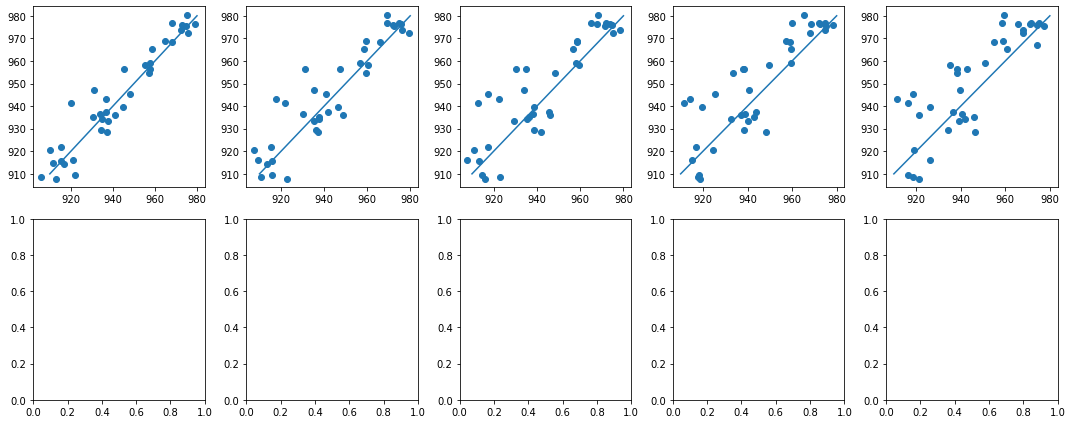

In [278]:
from sklearn.svm import SVR
print('RBF SVR')

# eps Parameter
units = [i for i in range(0,10)]

# gamma parameter
units2 = [2**i for i in range(-5,5)]

# Plot subplot
fig, axs = plt.subplots(2,5, tight_layout=True, figsize = (15,6))

# For each y, perform linear SVR
for i in range(5):
    Xtrain, ytrain, Xtest, ytest = train_test_split(X,y[i])
    
    # Determine C
    C1 = np.abs(ytrain[i].mean() + 3 * ytrain[i].std())
    C2 = np.abs(ytrain[i].mean() - 3 * ytrain[i].std())
    Cval = np.maximum(C1,C2)
    
    # Split into 5-fold for complexity tuning
    K = 5
    Xfold,yfold = kfold(Xtrain,ytrain,K)
    
    # For each parameter unit
    avgLrnError = np.zeros((len(units),len(units2)))
    avgValError = np.zeros((len(units),len(units2)))
    for idx,unit in enumerate(units): 
        for idx2,unit2 in enumerate(units2):
    
            # for each fold
            lrnError=np.zeros((K,))
            valError=np.zeros((K,))
            for k in range(K):
                Xlrn,ylrn,Xval,yval=get_lrn_val(Xfold,yfold,k,K)

                model = SVR(C=Cval,epsilon=unit,gamma=unit2,kernel='rbf')
                ypred_lrn = model.fit(Xlrn,ylrn).predict(Xlrn)
                lrnError[k] = metric.mean_squared_error(ylrn,ypred_lrn)

                ypred_val = model.predict(Xval)
                valError[k] = metric.mean_squared_error(yval,ypred_val)

            # Find average lrn and val error
            avgLrnError[idx,idx2] = lrnError.mean()
            avgValError[idx,idx2] = valError.mean()
    
    # Find lowest validation error and its corresponding parameter
    opt_params = np.unravel_index(np.argmin(avgValError, axis=None), avgValError.shape)
    opt_unit = units[opt_params[0]]
    opt_unit2 = units2[opt_params[1]]
    opt_val_error = np.min(avgValError)
    
    # Train using all training data on the optimal unit
    opt_model = SVR(C=Cval,epsilon=opt_unit,gamma=opt_unit2,kernel='rbf')
    ypred_trn = opt_model.fit(Xtrain,ytrain).predict(Xtrain)
    trnError = metric.mean_squared_error(ytrain,ypred_trn)
    
    # Test
    ypred_tst = opt_model.predict(Xtest)
    tstError = metric.mean_squared_error(ytest,ypred_tst)
    
    print('For model %d - opt eps:' % (i), opt_unit, 'opt C:', Cval, ' opt gamma: ', opt_unit2, ' train error: ', round(trnError,4), ' test error: ', round(tstError,4))
    
    # plot predicted y vs true y
    h = axs[0][i].scatter(ypred_tst,ytest)
    h = axs[0][i].plot(np.linspace(910,980),np.linspace(910,980))